**Import Libraries**

In [165]:
# Standard Libraries
import os
import random

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

**Define Parameters**

In [166]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

# Define parameters
SEED = 42
LEARNING_RATE = 0.001
EPOCHS =  3
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [167]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [168]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [169]:
# Define Disease Labels
disease_labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].apply(lambda x: 1 if 'No finding' in x else 0)

    # Map image filenames to their full paths
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(image_path, 'train', f"{x}.dicom"))
    
    return labels_df

# Path to the labels CSV file
train_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')
# test_csv_path = os.path.join(EXTRACTED_PATH, 'test.csv')

# Load and preprocess the labels
train_val_df = load_labels(train_csv_path, EXTRACTED_PATH)
# test_df = load_labels(test_csv_path, EXTRACTED_PATH)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
# print(f"Test size: {test_df.shape[0]}")

Train size: 67914


**Define Dataset for VinDr-CXR images**

In [170]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for VinDr-CXR images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']

        # Retrive image
        ds = pydicom.dcmread(img_path)
        img_array = ds.pixel_array.astype(np.float32)
        img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-5)
        img_array = np.stack([img_array] * 3, axis=-1)
        image = Image.fromarray((img_array * 255).astype(np.uint8))

        # Retrive boxes and labels
        boxes = self.df[['x_min', 'y_min', 'x_max', 'y_max']].values.astype(np.float32)
        labels = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations
        image = self.transform(image)
        
        return image, boxes, labels

**Define Data Transformations**

In [171]:
import torchvision.transforms as transforms

# Define transformations for training data with data augmentation
train_transforms = transforms.Compose([
    
    # Convert to grayscale and replicate channels to get 3 channels
    transforms.Grayscale(num_output_channels=3),
    
    # Resize the image to 224x224
    transforms.Resize((224, 224)),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [172]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
# test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [173]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [174]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Plot one sample from batch**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0648367].


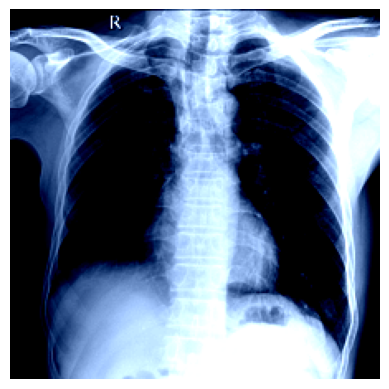

In [175]:
# Retrieve one batch of data from training loader
data_iter = iter(train_loader)
images, boxes, labels = next(data_iter)

# Select the first image
img = images[0]
label = labels[0]

# Convert to [H, W, C]
img = img.permute(1, 2, 0)

# Display
plt.imshow(img)
plt.axis('off')
plt.show()

# **Step 7: Build the Model**

**Initialize the Object Detection Model**

In [176]:
# Define the model
class ObjectDetectionModel(nn.Module):
    """
    Pre-trained model with classification and regression head.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(ObjectDetectionModel, self).__init__()

        # Load pre-trained model
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Classification head: predicts disease labels (multi-class for each image/box)
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

        # Regression head: predicts 4 bounding box coordinates (x_min, y_min, x_max, y_max)
        self.base_model.regressor = nn.Linear(self.base_model.classifier.in_features, 4)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = ObjectDetectionModel()
model.to(device)

ObjectDetectionModel(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

**Use Multiple GPUs**

In [177]:
model = nn.DataParallel(model)

**Define Loss Function and Optimizer**

In [178]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Regression loss for bounding boxes
reg_loss_fn = nn.SmoothL1Loss()

# Classification loss
cls_loss_fn = nn.CrossEntropyLoss()

# **Step 8: Train the Model**

In [179]:
def train_model(model, train_loader, val_loader, reg_loss_fn, cls_loss_fn, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """

    # List to store loss and mAP
    train_losses = []
    val_losses = []
    val_mAP = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, boxes, labels in progress_bar:
            inputs, boxes, labels = inputs.to(device), boxes.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            class_preds, bbox_preds = model(images)

            # Compute loss
            loss_bbox = reg_loss_fn(box_preds, boxes)
            loss_class = cls_loss_fn(class_preds, labels)
            loss = loss_box + loss_class

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, reg_loss_fn, cls_loss_fn, optimizer, epochs=EPOCHS)

Epoch 1/3:   0%|          | 0/1698 [00:00<?, ?it/s]

Epoch 1/3:   0%|          | 0/1698 [01:30<?, ?it/s]


ValueError: too many values to unpack (expected 2)

# **Step 8: Evaluate the Model**

In [ ]:
# TODO